<a href="https://colab.research.google.com/github/xinhe-zhang/heatwave/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IPCS Heatwave HW1**

Search two heatwave news, plot it and write what you have observed.
## **Event1:2020 Siberia Heatwave**
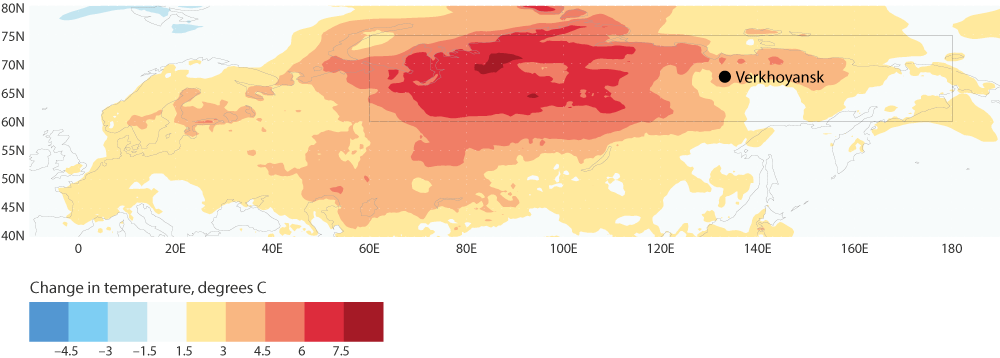
https://www.worldweatherattribution.org/siberian-heatwave-of-2020-almost-impossible-without-climate-change/
https://climate.copernicus.eu/esotc/2020/heat-siberia



In [48]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import axis as axis
import matplotlib.dates as mdates
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from datetime import datetime
from matplotlib.dates import DateFormatter

!pip install cartopy
import cartopy.crs as ccrs

In [3]:
#Download ERA5 Tmax, 1979-2022, land only, 144*73
#I've changed the data to my own drive.
!gdown https://drive.google.com/u/1/uc?id=14okWeTrUH1nHZcgbmBZupRM6s5EcVoYu&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=14okWeTrUH1nHZcgbmBZupRM6s5EcVoYu
To: /content/ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc
100% 676M/676M [00:09<00:00, 70.7MB/s]


In [4]:
filename = 'ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc'
ds = xr.open_dataset(filename)

In [10]:
print(ds)

<xarray.Dataset>
Dimensions:  (time: 16071, lon: 144, lat: 73)
Coordinates:
  * time     (time) int32 19790101 19790102 19790103 ... 20221230 20221231
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    mx2t     (time, lat, lon) float32 -24.38 -24.38 -24.38 ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Sep 05 13:41:31 2023: cdo chname,t2m,mx2t ERA5_SFC_mx2t...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


In [6]:
print(ds['mx2t'])

<xarray.DataArray 'mx2t' (time: 16071, lat: 73, lon: 144)>
[168938352 values with dtype=float32]
Coordinates:
  * time     (time) int32 19790101 19790102 19790103 ... 20221230 20221231
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Attributes:
    units:    m


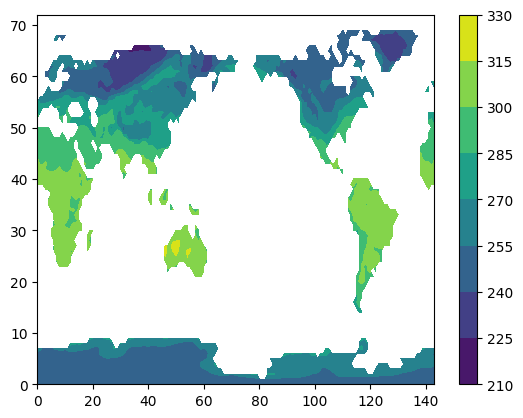

In [7]:
#Quick check
plt.contourf(ds['mx2t'][0,:,:])
plt.colorbar()

In [8]:
# Convert Kelvin to Celsius
ds = ds - 273.15

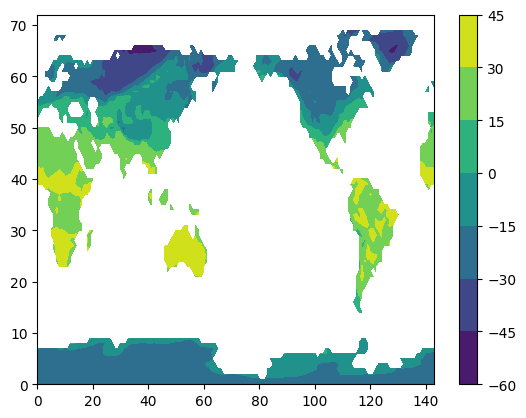

In [9]:
#Check again
plt.contourf(ds['mx2t'][0,:,:])
plt.colorbar()

In [11]:
#Write the time format
ds['time'] = ds['time'].astype('datetime64[ns]')
print(ds['time'].dtype)
print(ds['time'])

start_date = np.datetime64('1979-01-01')
end_date = np.datetime64('2023-01-01')  # Adjust the end date as needed

# Create a time array with intervals of 1 day
time_array = np.arange(start_date, end_date, np.timedelta64(1, 'D'))

print(time_array)
ds['time'] = time_array

datetime64[ns]
<xarray.DataArray 'time' (time: 16071)>
array(['1970-01-01T00:00:00.019790101', '1970-01-01T00:00:00.019790102',
       '1970-01-01T00:00:00.019790103', ..., '1970-01-01T00:00:00.020221229',
       '1970-01-01T00:00:00.020221230', '1970-01-01T00:00:00.020221231'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T00:00:00.019790101 ... 1970-01-...
Attributes:
    standard_name:  time
    long_name:      Date
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T
['1979-01-01' '1979-01-02' '1979-01-03' ... '2022-12-29' '2022-12-30'
 '2022-12-31']


In [12]:
#Select the month and location
ds_t2m=ds.sel(time=ds.time.dt.month.isin([6])).sel(lat=67.5, lon=130, method="nearest")

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [13]:
mx2t = ds_t2m['mx2t']
print(mx2t)

<xarray.DataArray 'mx2t' (time: 1320)>
array([ 2.6732178 ,  0.39715576,  1.433136  , ...,  5.6553345 ,
       14.040558  , 13.56839   ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2022-06-30
    lon      float64 130.0
    lat      float64 67.5


In [15]:
#filter 2020 June
x_2020_max = mx2t.sel(time=slice('2020-06-01', '2020-06-30'))
print(x_2020_max)
#now we got data only in the 30 days in June, 2020

<xarray.DataArray 'mx2t' (time: 30)>
array([ 9.525879 , 10.940521 ,  9.943268 ,  7.0035706, 12.126099 ,
       16.367584 , 18.905792 , 19.417328 , 14.270233 ,  3.7114868,
       11.85788  , 14.485016 , 15.052765 , 19.041107 , 16.863617 ,
       18.66867  , 20.802094 , 22.38266  , 24.947235 , 27.151031 ,
       28.141815 , 25.965271 , 26.225433 , 26.054504 , 25.74002  ,
       24.923676 , 25.255829 , 24.777466 , 20.811737 , 23.30014  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 2020-06-02 ... 2020-06-30
    lon      float64 130.0
    lat      float64 67.5


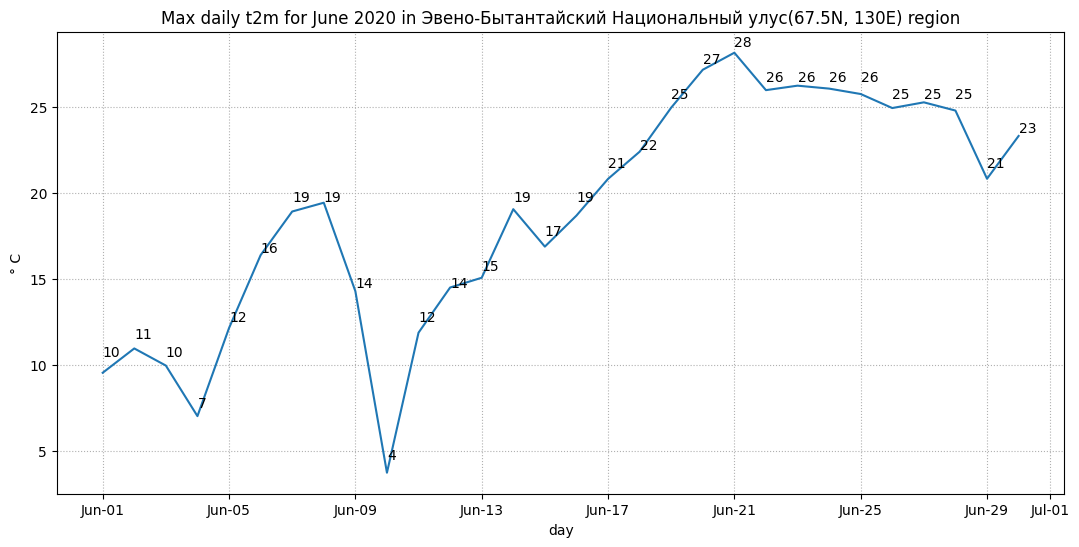

In [57]:
#a line plot that shows temperature fluctuation in June, 2002
fig, ax = plt.subplots(1, 1, figsize = (13, 6))
ax.plot(x_2020_max.time, x_2020_max)
ax.set_title('Max daily t2m for June 2020 in Эвено-Бытантайский Национальный улус(67.5N, 130E) region')
ax.set_ylabel('° C')
ax.set_xlabel('day')
ax.grid(linestyle='dotted')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#put the max.T value on each point
for i,j in zip(x_2020_max.time, np.around(x_2020_max.values, 0).astype(int)):
    ax.annotate(str(j),xy=(i,j+0.5))


In [59]:
print('The maximum temperature in June 2020 in this area was',
      np.around(x_2020_max.max().values, 2), 'degrees Celsius.')

The maximum temperature in June 2020 in this area was 28.14 degrees Celsius.


**Fig.1**

This plot shows the temperature variation in June 2020 at the location (67.5N, 130E), represented by the daily maximum two-meter temperature. There was a minor warming trend from June 4th to June 8th, followed by a sudden drop in temperature. Starting from June 10th, temperatures began to rise continuously, reaching a peak of 28.14°C on June 21st and remaining in a high-temperature state until the end of June.

In [60]:
#select data before 2020(included)
x_past = mx2t.loc['1979':'2020']
print(x_past)

<xarray.DataArray 'mx2t' (time: 1260)>
array([ 2.6732178 ,  0.39715576,  1.433136  , ..., 24.777466  ,
       20.811737  , 23.30014   ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2020-06-30
    lon      float64 130.0
    lat      float64 67.5


In [64]:
#select 10, 50, 90 quantile from the past
x_max_mid = mx2t.groupby('time.day').quantile(0.5)
x_max_90  = mx2t.groupby('time.day').quantile(0.9)
x_max_10  = mx2t.groupby('time.day').quantile(0.1)
print(x_max_10)
print(x_max_mid)
print(x_max_90)

<xarray.DataArray 'mx2t' (day: 30)>
array([1.43351746, 0.01387329, 1.5532074 , 2.26946411, 2.60884399,
       1.64988708, 2.79572144, 2.23360291, 2.78508301, 4.52483826,
       4.59788208, 2.64448547, 5.80215149, 5.78617554, 4.00228882,
       6.84390869, 7.74862366, 6.25111694, 5.06247253, 5.18581543,
       4.42095642, 4.09113159, 5.07986755, 6.62155457, 7.35142517,
       7.33447571, 5.73787842, 8.49860229, 7.58200989, 9.0649353 ])
Coordinates:
    quantile  float64 0.1
  * day       (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
<xarray.DataArray 'mx2t' (day: 30)>
array([ 8.13929749,  8.76219177,  9.35714722,  7.97956848,  9.17919922,
        9.98014832,  9.47103882, 10.81039429, 11.3681488 , 11.00364685,
       11.35986328, 13.46394348, 13.45100403, 13.29275513, 13.16325378,
       13.46987915, 14.81951904, 15.21989441, 15.15814209, 13.76452637,
       14.23878479, 13.02366638, 12.59794617, 14.55392456, 13.99278259,
       13.98143005, 14.51524353, 16.9311676 ,

<ipython-input-66-a9a17e45e077>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_2020_max.time.dt.day, x_2020_max, 'bo-', color='darkred', label='Daily max t2m June 2020')


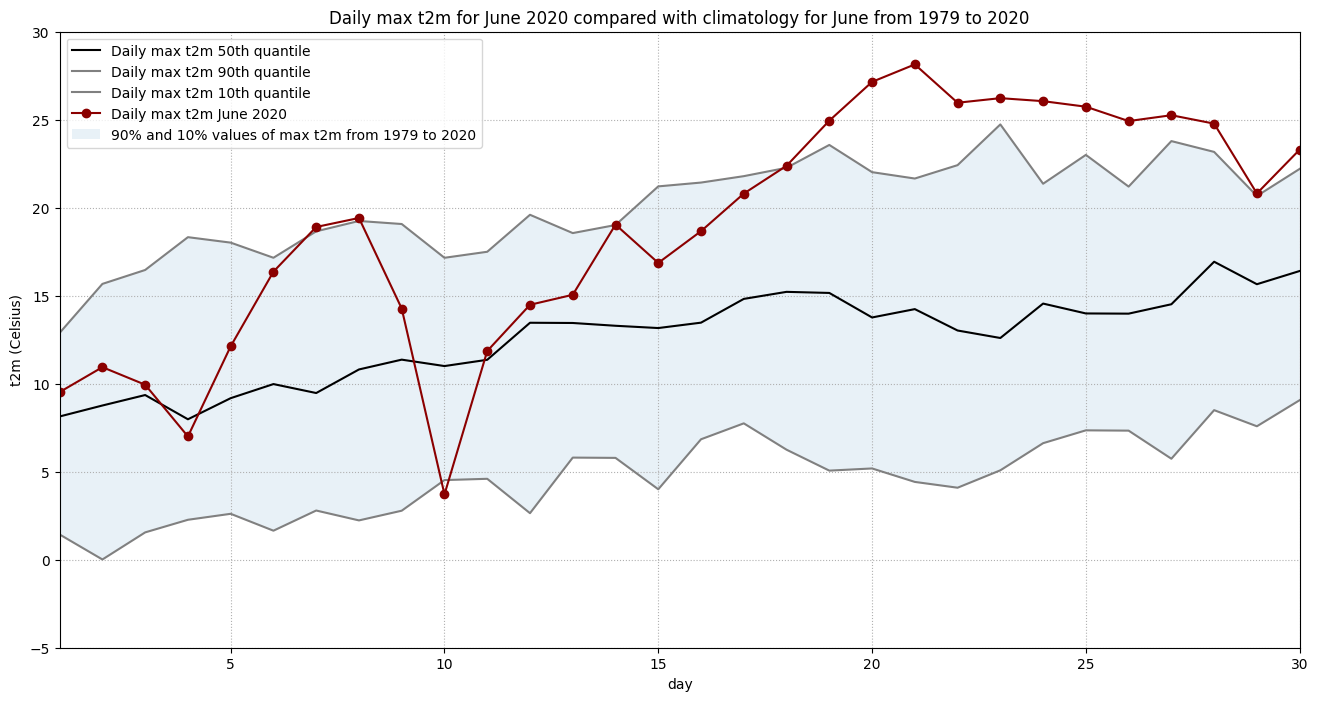

In [66]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot()

ax.plot(x_2020_max.time.dt.day, x_max_mid, color='black', label='Daily max t2m 50th quantile')
ax.plot(x_2020_max.time.dt.day, x_max_90, color='gray', label='Daily max t2m 90th quantile')
ax.plot(x_2020_max.time.dt.day, x_max_10, color='gray', label='Daily max t2m 10th quantile')
ax.plot(x_2020_max.time.dt.day, x_2020_max, 'bo-', color='darkred', label='Daily max t2m June 2020')
ax.fill_between(x_2020_max.time.dt.day, x_max_90, x_max_10, alpha=0.1,
                label='90% and 10% values of max t2m from 1979 to 2020')

ax.set_xlim(1,30)
ax.set_ylim(-5,30)
ax.set_title('Daily max t2m for June 2020 compared with climatology for June from 1979 to 2020')
ax.set_ylabel('t2m (Celsius)')
ax.set_xlabel('day')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='dotted')

**Fig.2**

To better understand whether there were indeed unusual temperature changes in June 2020 compared to previous years, Fig.2 shows the historical temperature range for this location from 1979 to June 2020, with the upper and lower bounds corresponding to the 90th and 10th quantiles, respectively. It can be observed that the slight warming from June 4th to June 8th generally remained within the 90th percentile range. However, during June 19th to June 30th, temperatures exceeded the 90th quantile line almost every day, indicating the occurrence of a heatwave during that period. Additionally, there was an unusual drop in temperature on June 10th, conveniently situated between the two warming events.

Then we will inspect the probability distribution of maximum temperatures for 21 June in this time period. To do this, we will first select only the max daily temperature for 21 June, for each year in the time series:

In [71]:
#selct only data on 21 June
x_21 = mx2t[20::30] #start from index 20, for an interval of 30
print(x_21)

<xarray.DataArray 'mx2t' (time: 44)>
array([ 7.522766 ,  8.411041 ,  1.9347229, 11.865509 , 14.327301 ,
       18.43863  , 10.553589 , 23.109161 ,  5.2833557, 15.658905 ,
        6.587158 , 15.538025 ,  4.2362976, 18.713165 , 14.150269 ,
       11.582001 , 13.834351 ,  4.345337 , 16.577393 , 22.337006 ,
       12.717163 ,  4.3958435,  9.413971 , 20.075287 ,  6.4478455,
        4.193512 , 17.294495 ,  9.981567 , 18.775085 , 16.57373  ,
       17.809265 , 13.926605 , 13.901184 ,  4.479553 , 16.964386 ,
       18.156647 , 14.956726 , 12.004974 , 16.299164 , 19.748383 ,
       23.049805 , 28.141815 , 26.396942 , 16.012604 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-21 1980-06-21 ... 2022-06-21
    lon      float64 130.0
    lat      float64 67.5


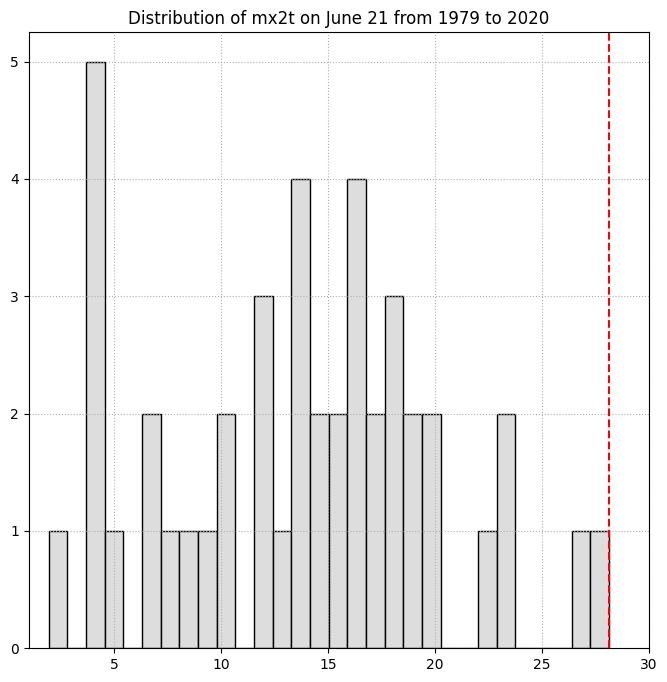

In [98]:
#plot the probability distribution
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
ax.hist(x_21, color = '#DDDDDD', ec = 'black',  bins=30)
ax.set_xlim(1,30)
ax.set_title('Distribution of mx2t on June 21 from 1979 to 2020')
plt.axvline(x = x_2020_max.max(), color = 'red', label = 'axvline - full height', linestyle='--')
ax.grid(linestyle='dotted')

**Fig.3**

This plot shows the distribution of the maximum temperature on June 21 from 1979 to 2020.The dashed red line represents the maximum temperature in 2020. It is apparent that the temperature in the past has never exceeded that in 2020.